In [1]:
# prerequisites:
# !pip install datacommons_pandas
# !pip install pandas
# !pip install matplotlib
# !pip install pycountry

# datacommons_pandas is a pandas-wrapped python data commons API installation
# pandas is a python library optimized for data manipulation and loading
# matplotlib is used for visualization purposes

In [2]:
!pip install datacommons_pandas

In [3]:
!pip install pycountry

In [4]:
import datacommons_pandas as dc
import pycountry
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
# import requests

In [5]:
class ts_scraper:
    def __init__(self, countries, stat_var):
        """ a class constructor that initializes attributes associated with scraping the data
        :param countries: list of countries to scrape data from implemented as nodes in a graph representing some country
        :param stat_var: dcid of statistical variable, implemented as information for graph nodes containing type of metric, statistic or measure that can measured at a place and time
        NOTE: to get full list of statistical variables to use, visit https://datacommons.org/tools/statvar (E.g: Area of Farm dcid -> Area_Farm)
        """
        self.countries = self.__get_country_dcid(countries)
        self.stat_var = stat_var
        self.__ts_columns = {}

    def __build_ts_df(self, places, country):
        """ builds a time=series dataframe
        :param places: dcids of places (dcids of counties, states, or cities)
        :param country: dcid of country
        :return: time-series dataframe in regard to the statistical variable
        """
        try:
            df_stats = dc.build_time_series_dataframe(places, self.stat_var)
            # adding name column (city, state, or name)
            df_stats['county_name'] = df_stats.index.map(dc.get_property_values(df_stats.index, 'name'))
            df_stats['county_name'] = df_stats['county_name'].str[0]
            return df_stats
        except:
            print('no data found for', country)
            return None
    def __get_country_dcid(self, country_names):
        """ retrieves associated three-letter code of country
            :param country_names: list of countries provided
            :return: list of countries and their corresponding three-letter code
            NOTE: mistyped countiry names will not be included in the returned list
            """
        country_dcids = {}
        for country_name in country_names:
            country = pycountry.countries.get(name=country_name)
            if country is None:
                print("Country name typed invalid! no code can be provided for " + country_name)
            else:
                code = country.alpha_3
                country_dcid = 'country/' + code
                country_dcids[country_name] = country_dcid
                # country_dcids.append(country_dcid)

        return country_dcids

    def scrape_data(self, place_type):
        """ scrapes the data in regard to the statistical variable (depending on place type)
        :param place_type: type of location required within a country (state, county, city)
        :return: dataframe of data gathered (time series data)
        """
        dfs_collected = {}
        country_dcid = list(self.countries.values())
        for country in country_dcid:
            if place_type == 'state':
                states_each_country = dc.get_places_in(country_dcid, 'State')
                states = states_each_country[country]
                df_stats = self.__build_ts_df(states, country)
            elif place_type == 'county':
                counties_each_country = dc.get_places_in(country_dcid, 'County')
                counties = counties_each_country[country]
                df_stats = self.__build_ts_df(counties, country)
            elif place_type == 'city':
                cities_each_country = dc.get_places_in(country_dcid, 'City')
                cities = cities_each_country[country]
                df_stats = self.__build_ts_df(cities, country)
            else:
                print("ERROR type of place not specified!")
                return None
            dfs_collected[self.stat_var + "_" + country[8:] + '_ts'] = df_stats
        return dfs_collected

    def __standardize_years(self, df):
        standardized_years = []
        for col in df.columns[:-1]:  # except last column which is not year column
            col = pd.to_datetime(col).year
            col = str(col)
            standardized_years.append(col)
        standardized_years.append(df.columns[-1])
        df.columns = standardized_years
        return df
    def __calc_sample_frequency(self, df):
        start_year = int(df.columns[0])
        years = list(map(int, df.columns[:-1]))
        diffs = []
        for row in df.iterrows():
            prev = start_year
            later = -1
            count = 0
            diff = 0
            row = list(row[1].iloc)[:-1]
            for i, value in enumerate(row):
                later = -1
                if pd.isna(value):
                    continue
                else:
                    later = i
                    diff = diff + (years[later] - prev)
                    count += 1
                    prev = years[later]
            diff = diff + (years[later] - prev)
            count += 1
            diffs.append(diff / count)
        df['sample_frequency'] = diffs
        return df
    def __conform_to_standard(self, df, df_name):
        start_date = df.columns[0]
        end_date = df.columns[-2]

        # 1 sample frequency
        df = self.__standardize_years(df)
        df = self.__calc_sample_frequency(df)


        df['timestamps'] = '{' + '{}:{}'.format(start_date, end_date) + '}'

        df['name'] = self.stat_var + "_over_time"

        df['units'] = 'year' # statistical variables are measured year-by-year

        df['url'] = 'https://datacommons.org/tools/statvar#' + self.stat_var

        df['domain'] = df.dtypes[0]  # 0 indicates the first column in the times-series data (one of the periods)

        country_code = df_name.split('_')[-2]
        country_name = list(self.countries.keys())[list(self.countries.values()).index('country/'+country_code)]
        df['country_code'] = country_code
        df['country_name'] = country_name

        # NOTE there was a problem with retrieving wikidata names using the API, so instead we're going to store wikidata ids for county, state, city
        # NOTE another is length of each set, which means need to find relations between county and state and city to add their data accordingly
        # if(self.__county_names[country_code])
        # df['county'] = self.__county_names[country_code]
        # df['state'] = self.__state_names[country_code]
        # df['city'] = self.__city_names[country_code]
        # print(df)

        df['original_id'] = df.index
        df = df.reset_index()
        df['aug_id'] = df.index
        return df

    def generate_csv_dataset(self, dfs):
        for df_name in dfs.keys():
            df = dfs[df_name]
            conformed_df = self.__conform_to_standard(df, df_name)
            path = os.curdir + '/Generated Datasets/'
            if not os.path.exists(path):
                os.makedirs(path)
                conformed_df.to_csv('Generated Datasets/' + df_name + ".csv")
            else:
                conformed_df.to_csv('Generated Datasets/' + df_name + ".csv")

    def explore_and_visualize_df(self, df_name, df):
        print('-' * 100)
        ts_title = " ".join(df_name.split('_')[:-2]) + " over time (for country " + df_name.split('_')[-2] + ')'

        print('--------dataframe: ', ts_title + '--------')
        ts_columns = df.columns[:-10]
        ts_data = df[ts_columns].T
        print()

        print('--------first look into dataframe', ts_title + '--------')
        print(ts_data.head(5))
        print()

        print('--------dataframe info--------')
        print(ts_data.info())
        print()

        print('--------visualization for first variable--------')
        # ts_data['year'] = ts_data.index
        print(ts_data)
        sns.set_style('darkgrid')
        sns.set(rc={'figure.figsize': (14, 8)})
        print(ts_data.index.is_unique)
        print(ts_data.index.duplicated())
        ax = sns.lineplot(data=ts_data, x=ts_data.index, y=ts_data.columns[0], palette='viridis', legend='full', lw=3)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
        plt.legend(ts_data.columns[0])
        plt.ylabel(ts_data.columns[0])
        plt.xlabel('Year')
        plt.show()

In [6]:
stat_var = 'Count_Person'
countries = ['American Samoa', 'Canada', 'France', 'United Kingdom']
# countries = ['Canada']

----------------------------------------------------------------------------------------------------
--------dataframe:  Count Person over time (for country ASM)--------

--------first look into dataframe Count Person over time (for country ASM)--------
place  geoId/6062500  wikidataId/Q5455450
2010            3656                  153

--------dataframe info--------
<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 2010 to 2010
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   geoId/6062500        1 non-null      int64
 1   wikidataId/Q5455450  1 non-null      int64
dtypes: int64(2)
memory usage: 24.0+ bytes
None

--------visualization for first variable--------
place  geoId/6062500  wikidataId/Q5455450
2010            3656                  153
True
[False]


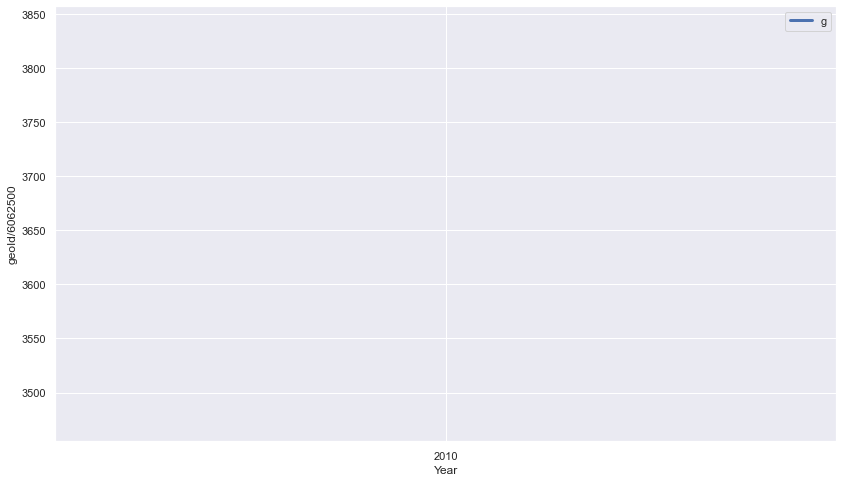

----------------------------------------------------------------------------------------------------
--------dataframe:  Count Person over time (for country CAN)--------

--------first look into dataframe Count Person over time (for country CAN)--------
place  wikidataId/Q1000316  wikidataId/Q1001461  wikidataId/Q1001646  \
1996                   NaN                  NaN                  NaN   
2001                   NaN                  NaN                  NaN   
2006                   NaN                  NaN                  NaN   
2009                   NaN                  NaN                  NaN   
2011                   NaN                  NaN                344.0   

place  wikidataId/Q1001810  wikidataId/Q1001811  wikidataId/Q1004103  \
1996                   NaN                  NaN                  NaN   
2001                   NaN                  NaN                  NaN   
2006                   NaN                  NaN                  NaN   
2009                   Na

C:\Users\user\anaconda3\lib\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

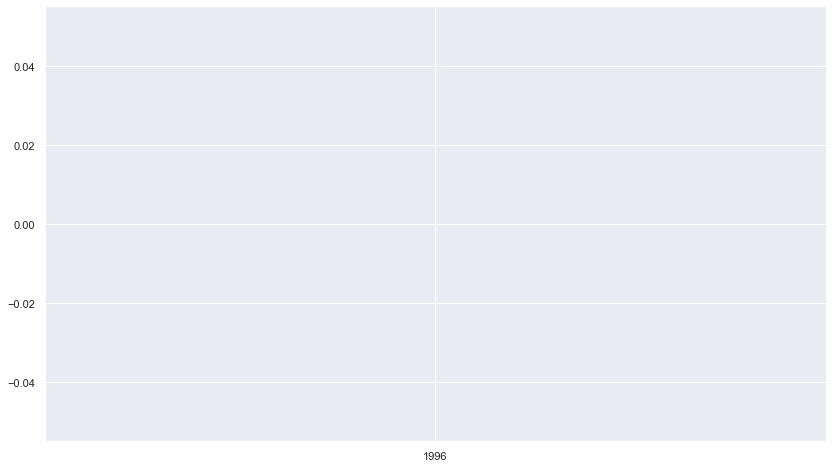

In [7]:
scraper = ts_scraper(countries, stat_var)
dfs = scraper.scrape_data('city')
scraper.generate_csv_dataset(dfs)
for df_i_name, df_i in dfs.items():
    scraper.explore_and_visualize_df(df_i_name, df_i)